In [ ]:
import json
import sys
import os
from PIL import Image, ImageDraw

In [ ]:
# import the library
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)

from svglib.svg import SVG
from svglib.geom import Point

In [ ]:
sample_dir = os.path.join(root_dir, "samples")
coords = json.load(open(os.path.join(sample_dir, "placing.json")))  # a file that tells you where to place a series of SVGs in a canvas 

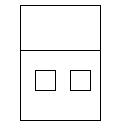

In [57]:
# draw the bounding boxes that tells where to place all the SVGs 
img = Image.new('RGB', (128, 128), color='white')
draw = ImageDraw.Draw(img)
for _, c in coords.items():
    x, y, x2, y2 = c['bounding_box']
    draw.rectangle([x, y, x2, y2], outline="black", fill=None)
img

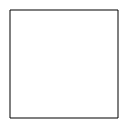

In [63]:
# display one SVG
svg_path = os.path.join(sample_dir, coords["house_body"]["file"])
svg = SVG.load_svg(svg_path)
svg.draw(do_display=True)

In [60]:
# let's take the first square, and scale it to fit its bounding box in the canvas

def compute_scale_shift(x1, y1, x2, y2):
    orig_w, orig_h = (128, 128)  # the original size of the svg file
    new_w, new_h = (x2 - x1, y2 - y1)  # the size of the bounding box
    width_ratio = new_w / orig_w
    height_ratio = new_h / orig_h
    print(new_w, new_h, width_ratio, height_ratio)

    # if the bounding box is not square, we need to scale it to the smallest dimension and center it
    if width_ratio != height_ratio:
        scale_factor = min(width_ratio, height_ratio)
        shift = (
            abs(new_h - new_w) // 2 if width_ratio > height_ratio else 0, 
            abs(new_h - new_w) // 2 if height_ratio > width_ratio else 0
            )
    else: 
        scale_factor = width_ratio
        shift = (0, 0)

    return scale_factor, shift


(x1, y1, x2, y2) = coords["house_body"]["bounding_box"]
scale_factor, shift = compute_scale_shift(x1, y1, x2, y2)
print(scale_factor, shift)


80 70 0.625 0.546875
0.546875 (5, 0)


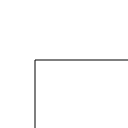

In [64]:
# let's now translate everything to the top-left coordinate of the bounding box and add the shift

# fist remove the viewBox
# svg.translate(-svg.viewbox.center)
# svg.draw(do_display=True)
svg.translate(Point(x1, y1) + Point(*shift))
svg.draw(do_display=True)




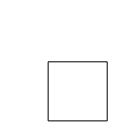

In [65]:
svg.zoom(scale_factor)
svg.draw(do_display=True)


In [93]:
svg = SVG.load_svg(svg_path)

In [92]:
svg.svg_path_groups[0]

SVGLine(xy1=P(10.0, 10.0) xy2=P(118.0, 10.0))

In [ ]:
def merge_svg_files(coordinates, file_dir):
    image_size = (128, 128)  # Original image dimensions (width, height)
    for key, coords in coordinates.items():
        file = coords["file"]
        (x1, y1, x2, y2) = coords["bounding_box"]
        width_ratio = (x2 - x1) / image_size[0]
        height_ratio = (y2 - y1) / image_size[1]
        assert width_ratio == height_ratio, "Width and height ratios should be equal."

        svg = SVG.load_svg(os.path.join(file_dir, file))
        svg.zoom(width_ratio)
        
        from svglib.geom import Point
        target_center = Point(x1, y1)
        svg.translate(target_center)

        svg.save_svg(os.path.join(file_dir, "out.svg"))